# Downloading and Reading the CSI Dataset

In [1]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.manifold import trustworthiness
from scipy.sparse.csgraph import dijkstra
from scipy.spatial import distance_matrix
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import multiprocessing as mp
import tensorflow as tf
import numpy as np
import progressbar
import random
import queue
import json
import DeepMIMO
from scipy.io import loadmat, savemat
import glob
import re
from tqdm import tqdm
from pprint import pprint
import os
import pickle
from adp_utils import compute_adp_dissimilarity_matrix
from geodesic_utils import compute_geodesic_dissimilarity_matrix

plt.rcParams['figure.figsize'] = [12,8]#设置画布大小
## Antenna definitions
# ASSIGNMENTS = [
# 	[0, 13, 31, 29, 3, 7, 1, 12 ],
# 	[30, 26, 21, 25, 24, 8, 22, 15],
# 	[28, 5, 10, 14, 6, 2, 16, 18],
# 	[19, 4, 23, 17, 20, 11, 9, 27]
# ]

# ANTENNACOUNT = np.sum([len(antennaArray) for antennaArray in ASSIGNMENTS])


---
## 使用DeepMIMO生成信道

In [2]:
parameters = DeepMIMO.default_params()
parameters['scenario'] = 'O1_60' #数据集名称
parameters['dataset_folder'] = r'E:\Files\Project\deepMIMO_dataset' #数据集路径
parameters['num_path'] = 5 #多径数量
parameters['user_row_first'] = 1100
parameters['user_row_last'] = 1300 #选择地图网格中1000-1300行的用户
parameters['row_subsampling'] = 0.5 #行采样比例
parameters['user_subsampling'] = 0.5 #用户采样比例
parameters['active_BS'] = np.array([3,6]) #选择3，6号基站
parameters['OFDM']['bandwidth'] = 0.5 #选择OFDM基带信号带宽0.5代表50MHz
parameters['OFDM']['subcarriers'] = 1024 #指定子载波数量
parameters['OFDM']['subcarriers_limit'] = 16 #限定前64个子载波
parameters['enable_BS2BS'] = False
parameters['ue_antenna']['shape'] = np.array([1,1,1]) #设置用户天线阵列形状1*1*1也即单天线
parameters['bs_antenna']['shape'] = np.array([1,16,4]) #设置基站天线形状1*32*8，即32行8列的ULA
parameters['bs_antenna']['radiation_pattern'] = 'halfwave-dipole'
parameters['ue_antenna']['radiation_pattern'] = 'halfwave-dipole'
pprint(parameters, sort_dicts = False)


# file_path = 'DeepMIMO_dataset.pkl'
# 检查文件是否存在
# if os.path.exists(file_path):
#     # 如果文件存在，读取数据
#     with open(file_path, 'rb') as f:
#         dataset = pickle.load(f)
# else:
#     # 如果文件不存在，生成数据
#     dataset = DeepMIMO.generate_data(parameters)
#
#     # 保存数据到文件
#     with open(file_path, 'wb') as f:
#         pickle.dump(dataset, f, protocol=4)
dataset = DeepMIMO.generate_data(parameters)

NF = 5  # 基站处噪声系数
Process_Gain = 10 #信道估计增益
BW = parameters['OFDM']['bandwidth'] * 1e9 #系统工作在6GHz
noise_power_dB = -204 + 10*np.log10(BW/parameters['OFDM']['subcarriers']) + NF - Process_Gain # 噪声功率
noise_power = 10 ** (.1*(noise_power_dB)) #噪声功率

num_OFDM = int(parameters['OFDM']['subcarriers_limit']/parameters['OFDM']['subcarriers_sampling'])
num_bs = len(parameters['active_BS'])
num_ue = len(parameters['active_UE'])

{'dataset_folder': 'E:\\Files\\Project\\deepMIMO_dataset',
 'scenario': 'O1_60',
 'dynamic_settings': {'first_scene': 1, 'last_scene': 1},
 'num_paths': 5,
 'active_BS': array([3, 6]),
 'user_row_first': 1100,
 'user_row_last': 1300,
 'row_subsampling': 0.5,
 'user_subsampling': 0.5,
 'bs_antenna': {'shape': array([ 1, 16,  4]),
                'spacing': 0.5,
                'radiation_pattern': 'halfwave-dipole'},
 'ue_antenna': {'shape': array([1, 1, 1]),
                'spacing': 0.5,
                'radiation_pattern': 'halfwave-dipole'},
 'enable_BS2BS': False,
 'OFDM_channels': 1,
 'OFDM': {'subcarriers': 1024,
          'subcarriers_limit': 16,
          'subcarriers_sampling': 1,
          'bandwidth': 0.5,
          'RX_filter': 0},
 'num_path': 5}

Basestation 3

UE-BS Channels


Generating channels: 100%|██████████| 9000/9000 [00:00<00:00, 13225.47it/s]



Basestation 6

UE-BS Channels


Generating channels: 100%|██████████| 9000/9000 [00:00<00:00, 12656.56it/s]


In [3]:

## DeepMIMO生成的信道没有时间戳吗？同一个散射簇内的径没有时延也即没有相位差，只存在离开角到达角的差异，不同散射簇之间存在时延，光速乘上时延反映了UE或BS到达散射簇的距离，也反映在相位差上
csi = np.empty((num_bs,num_ue,64,16), dtype=np.complex)
groundtruth_positions = np.empty((num_bs,num_ue, 2), dtype=np.float64)

for i in range(2):
	csi[i] = dataset[i]['user']['channel'][:,0,:,:]
	groundtruth_positions[i] = dataset[i]['user']['location'][:, 0:2]
groundtruth_positions = groundtruth_positions[0]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_2208\1228042295.py:2: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  csi = np.empty((num_bs,num_ue,64,16), dtype=np.complex)


In [3]:
pprint(parameters['bs_antenna'])

{'radiation_pattern': 'halfwave-dipole',
 'shape': array([ 1, 16,  4]),
 'spacing': 0.5}


In [4]:
## 将频域信道转换为时域
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
csi_time_domain = []
csi_tf = tf.convert_to_tensor(csi, dtype=tf.complex128)
csi_tf_ifft = tf.signal.fftshift(tf.signal.ifft(tf.signal.fftshift(csi_tf, axes=3)), axes=3)
csi_time_domain = csi_tf_ifft.numpy()
del csi_tf_ifft, csi_tf
csi_time_domain = np.transpose(csi_time_domain,(1,0,2,3))


Num GPUs Available:  1


In [ ]:
# Decimate dataset: Use only every 4th datapoint (to reduce number of points)
# training_set = full_dataset.enumerate().filter(lambda idx, value : (idx % 4 == 0))
# training_set = training_set.map(lambda idx, value : value)

# From TensorFlow to NumPy

In [ ]:
# groundtruth_positions = []
# csi_time_domain = []
# timestamps = []
#
# for csi, pos, time in training_set.batch(1000):
# 	csi_time_domain.append(csi.numpy())
# 	groundtruth_positions.append(pos.numpy())
# 	timestamps.append(time.numpy())
#
# csi_time_domain = np.concatenate(csi_time_domain)
# groundtruth_positions = np.concatenate(groundtruth_positions)
# timestamps = np.concatenate(timestamps)

# Visualizing the Dataset

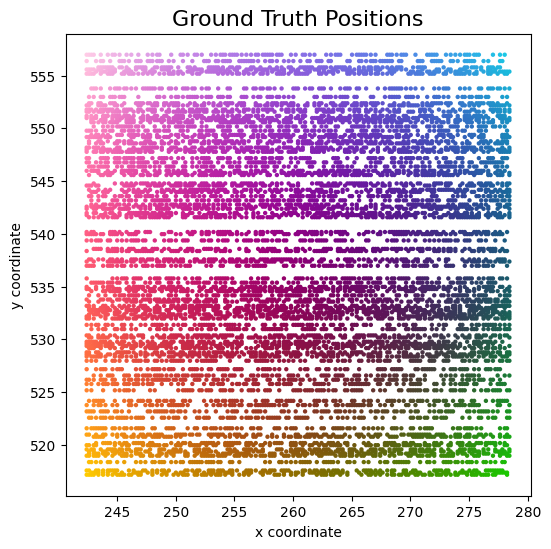

In [14]:
def plot_colorized(positions, groundtruth_positions, title = None, show = True, alpha = 1.0):
	# Generate RGB colors for datapoints
	center_point = np.zeros(2, dtype = np.float32)
	center_point[0] = 0.5 * (np.min(groundtruth_positions[:, 0], axis = 0) + np.max(groundtruth_positions[:, 0], axis = 0))
	center_point[1] = 0.5 * (np.min(groundtruth_positions[:, 1], axis = 0) + np.max(groundtruth_positions[:, 1], axis = 0))
	NormalizeData = lambda in_data : (in_data - np.min(in_data)) / (np.max(in_data) - np.min(in_data))
	rgb_values = np.zeros((groundtruth_positions.shape[0], 3))
	rgb_values[:, 0] = 1 - 0.9 * NormalizeData(groundtruth_positions[:, 0])
	rgb_values[:, 1] = 0.8 * NormalizeData(np.square(np.linalg.norm(groundtruth_positions - center_point, axis=1)))
	rgb_values[:, 2] = 0.9 * NormalizeData(groundtruth_positions[:, 1])

	# Plot datapoints
	plt.figure(figsize=(6, 6))
	if title is not None:
		plt.title(title, fontsize=16)
	plt.scatter(positions[:, 0], positions[:, 1], c = rgb_values, alpha = alpha, s = 10, linewidths = 0)
	plt.xlabel("x coordinate")
	plt.ylabel("y coordinate")
	if show:
		plt.show()

plot_colorized(groundtruth_positions, groundtruth_positions, title="Ground Truth Positions")

# 相异性矩阵的计算

### 1: ADP-based dissimilarity matrix

In [5]:
adp_dissimilarity_matrix = np.zeros((csi_time_domain.shape[0], csi_time_domain.shape[0]),dtype=np.float32)

# jupyter只能跟踪主进程，无法跟踪子进程，需要把要调用的函数封装到.py文件
adp_dissimilarity_matrix = compute_adp_dissimilarity_matrix(csi_time_domain)

100% (81000000 of 81000000) |############| Elapsed Time: 0:04:34 Time:  0:04:34


In [6]:
# Fuse ADP-based and time-based dissimilarity matrices
dissimilarity_matrix_fused = adp_dissimilarity_matrix

### 2: Geodesic Dissimilarity Matrix

In [7]:
n_neighbors = 20

nbrs_alg = NearestNeighbors(n_neighbors = n_neighbors, metric="precomputed", n_jobs = -1)
nbrs = nbrs_alg.fit(dissimilarity_matrix_fused)
nbg = kneighbors_graph(nbrs, n_neighbors, metric = "precomputed", mode="distance")

In [10]:
dissimilarity_matrix_geodesic = np.zeros((nbg.shape[0], nbg.shape[1]), dtype = np.float32)

# 同样的jupyter只能跟踪主进程，无法跟踪子进程，需要把要调用的函数封装到.py文件
dissimilarity_matrix_geodesic = compute_geodesic_dissimilarity_matrix(nbg)


100% (81000000 of 81000000) |############| Elapsed Time: 0:00:00 Time:  0:00:00


In [11]:
# Compute distances between groundtruth positions
groundtruth_distance_matrix = distance_matrix(groundtruth_positions, groundtruth_positions)

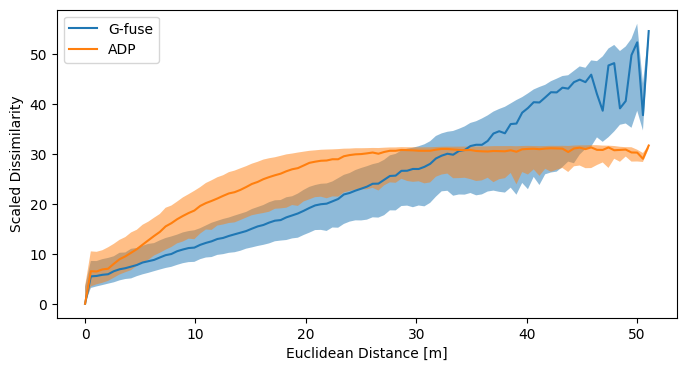

In [12]:
def plot_dissimilarity_over_euclidean_distance(dissimilarity_matrix, distance_matrix, label = None):
	nth_reduction = 10
	dissimilarities_flat = dissimilarity_matrix[::nth_reduction, ::nth_reduction].flatten()
	distances_flat = distance_matrix[::nth_reduction, ::nth_reduction].flatten()
	
	max_distance = np.max(distances_flat)
	bins = np.linspace(0, max_distance, 100)
	bin_indices = np.digitize(distances_flat, bins)
	
	bin_medians = np.zeros(len(bins) - 1)
	bin_25_perc = np.zeros(len(bins) - 1)
	bin_75_perc = np.zeros(len(bins) - 1)
	for i in range(1, len(bins)):
		bin_values = dissimilarities_flat[bin_indices == i]
		bin_25_perc[i - 1], bin_medians[i - 1], bin_75_perc[i - 1] = np.percentile(bin_values, [25, 50, 75])
	
	plt.plot(bins[:-1], bin_medians, label = label)
	plt.fill_between(bins[:-1], bin_25_perc, bin_75_perc, alpha=0.5)
	
plt.figure(figsize=(8,4))
plot_dissimilarity_over_euclidean_distance(dissimilarity_matrix_geodesic, groundtruth_distance_matrix, "G-fuse")
plot_dissimilarity_over_euclidean_distance(adp_dissimilarity_matrix, groundtruth_distance_matrix, "ADP")

plt.legend()
plt.xlabel("Euclidean Distance [m]")
plt.ylabel("Scaled Dissimilarity")
plt.show()

# 生成信道图

### MDS / Isomap

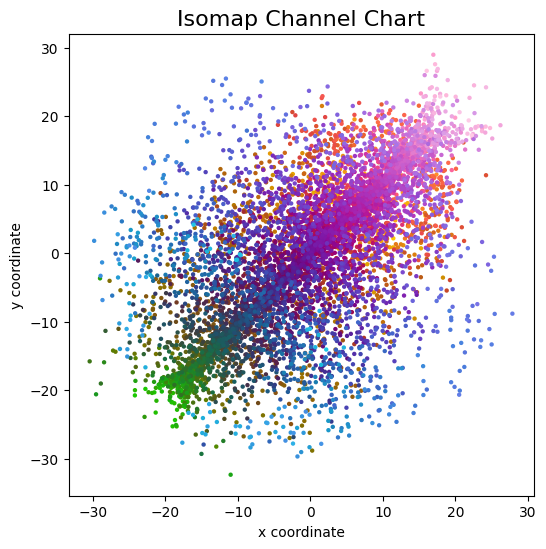

In [15]:
nth_reduction = 1
reduced_dissimilarity_matrix_geodesic = dissimilarity_matrix_geodesic[::nth_reduction, ::nth_reduction]
embedding_isomap = MDS(metric = True, dissimilarity = 'precomputed', max_iter = 80, normalized_stress = False)
proj_isomap = embedding_isomap.fit_transform(reduced_dissimilarity_matrix_geodesic)
plot_colorized(proj_isomap, groundtruth_positions[::nth_reduction], title = "Isomap Channel Chart")

### 特征提取

In [17]:
class FeatureEngineeringLayer(tf.keras.layers.Layer):
	def __init__(self):
		super(FeatureEngineeringLayer, self).__init__(dtype = tf.complex64)

	def call(self, csi):
        # 计算整个系统中两个天线的任意组合在相同数据点和时间刻度上的样本自相关
        # 对于相同的数据点和时间刻度，计算csi的任意两个天线的样本自相关
		sample_autocorrelations = tf.einsum("damt,dbnt->dtabmn", csi, tf.math.conj(csi))
		return tf.stack([tf.math.real(sample_autocorrelations), tf.math.imag(sample_autocorrelations)], axis = -1)

### Autoencoder(DNN)

In [20]:
from tensorflow.keras import backend as K
K.clear_session()

In [19]:
array_count = np.shape(csi_time_domain)[1]
antenna_per_array_count = np.shape(csi_time_domain)[2]
tap_count = np.shape(csi_time_domain)[3]

cc_embmodel_input = tf.keras.Input(shape=(array_count, antenna_per_array_count, tap_count), name="input", dtype = tf.complex64)
cc_embmodel_output = FeatureEngineeringLayer()(cc_embmodel_input)
cc_embmodel_output = tf.keras.layers.Flatten()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(1024, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(512, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(256, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(128, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(64, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(2, activation = "linear")(cc_embmodel_output)

cc_embmodel = tf.keras.Model(inputs=cc_embmodel_input, outputs=cc_embmodel_output, name = "ForwardChartingFunction")

ResourceExhaustedError: OOM when allocating tensor with shape[524288,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

### Siamese Neural Network

In [ ]:
dissimilarity_margin = np.quantile(dissimilarity_matrix_geodesic, 0.01)

def siamese_loss(y_true, y_pred):
    y_true = y_true[:,0]
    pos_A, pos_B = (y_pred[:,:2], y_pred[:,2:])
    distances_pred = tf.math.reduce_euclidean_norm(pos_A - pos_B, axis = 1)

    return tf.reduce_mean(tf.square(distances_pred - y_true) / (y_true + dissimilarity_margin))

In [ ]:
input_A = tf.keras.layers.Input(shape = (array_count, antenna_per_array_count, tap_count,), dtype = tf.complex64)
input_B = tf.keras.layers.Input(shape = (array_count, antenna_per_array_count, tap_count,), dtype = tf.complex64)

embedding_A = cc_embmodel(input_A)
embedding_B = cc_embmodel(input_B)

output = tf.keras.layers.concatenate([embedding_A, embedding_B], axis=1)
model = tf.keras.models.Model([input_A, input_B], output, name = "SiameseNeuralNetwork")

### Sample Selection

In [ ]:
csi_time_domain_tensor = tf.constant(csi_time_domain)
dissimilarity_matrix_geodesic_tensor = tf.constant(dissimilarity_matrix_geodesic)

datapoint_count = tf.shape(csi_time_domain_tensor)[0].numpy()

random_integer_pairs_dataset = tf.data.Dataset.zip(tf.data.Dataset.random(), tf.data.Dataset.random())

@tf.function
def fill_pairs(randA, randB):
    return (csi_time_domain_tensor[randA % datapoint_count], csi_time_domain_tensor[randB % datapoint_count]), dissimilarity_matrix_geodesic_tensor[randA % datapoint_count, randB % datapoint_count]

random_pair_dataset = random_integer_pairs_dataset.map(fill_pairs)

### Training

In [ ]:
optimizer = tf.keras.optimizers.Adam()
model.compile(loss = siamese_loss, optimizer = optimizer)

samples_per_session = 150000
learning_rates = [1e-2, 1e-2, 8e-3, 4e-3, 1e-3, 5e-4, 2e-4, 1e-4]
batch_size = [500, 1000, 1500, 2000, 3000, 4000, 5000, 6000]

for l in range(len(learning_rates)):
    print("\nTraining Session ", l + 1, "\nBatch Size: ", batch_size[l], "\nLearning rate: ", learning_rates[l])

    # Fit model
    optimizer.learning_rate.assign(learning_rates[l])
    model.fit(random_pair_dataset.batch(batch_size[l]).prefetch(tf.data.AUTOTUNE), steps_per_epoch = samples_per_session // batch_size[l])

    # Plot Channel Chart
    print("Running inference to plot channel chart")
    channel_chart_positions = cc_embmodel.predict(csi_time_domain)
    plot_colorized(channel_chart_positions, groundtruth_positions, title = "Siamese-Based Channel Chart - Session " + str(l + 1))

# Evaluation: Optimal Affine Transform and Mean Absolute Error

In [ ]:
channel_chart_positions = cc_embmodel.predict(csi_time_domain)

def affine_transform_channel_chart(groundtruth_pos, channel_chart_pos):
    pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
    unpad = lambda x: x[:,:-1]
    A, res, rank, s = np.linalg.lstsq(pad(channel_chart_pos), pad(groundtruth_pos), rcond = None)
    transform = lambda x: unpad(np.dot(pad(x), A))
    return transform(channel_chart_pos)

channel_chart_positions_transformed = affine_transform_channel_chart(groundtruth_positions, channel_chart_positions)
plot_colorized(groundtruth_positions, groundtruth_positions, title = "Ground Truth Positions")
plot_colorized(channel_chart_positions_transformed, groundtruth_positions, title = "Channel Chart After Affine Transform")

In [ ]:
errorvectors = groundtruth_positions - channel_chart_positions_transformed
errors = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
mae = np.mean(errors)

nth_errorvector = 15
plot_colorized(channel_chart_positions_transformed, groundtruth_positions, title = "Error Vectors, MAE = " + str(mae) + "m", show = False, alpha = 0.3)
plt.quiver(channel_chart_positions_transformed[::nth_errorvector, 0], channel_chart_positions_transformed[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.show()

In [ ]:
count, bins_count = np.histogram(errors, bins=200)
pdf = count / sum(count)
cdf = np.cumsum(pdf)

bins_count[0] = 0
cdf = np.append([0], cdf)

plt.figure(figsize=(5, 4))
plt.plot(bins_count, cdf)
plt.xlim((0, 2))
plt.xlabel("Absolute Localization Error [m]")
plt.ylabel("CDF")
plt.grid()
plt.show()

# Evaluation: Continuity, Trustworthiness, Kruskal Stress

In [ ]:
# Continuity is identical to trustworthiness, except that original space and embedding space are swapped
def continuity(*args, **kwargs):
	args = list(args)
	args[0], args[1] = args[1], args[0]
	return trustworthiness(*args, **kwargs)

def kruskal_stress(X, X_embedded):
	dist_X = distance_matrix(X, X)
	dist_X_embedded = distance_matrix(X_embedded, X_embedded)
	beta = np.divide(np.sum(dist_X * dist_X_embedded), np.sum(dist_X_embedded * dist_X_embedded))

	return np.sqrt(np.divide(np.sum(np.square((dist_X - beta * dist_X_embedded))), np.sum(dist_X * dist_X)))

In [ ]:
# Evaluate CT / TW / KS on a subset of the whole dataset
subset_indices = random.sample(range(len(groundtruth_positions)), len(groundtruth_positions) // 5)
groundtruth_positions_subset = groundtruth_positions[subset_indices]
channel_chart_positions_subset = channel_chart_positions[subset_indices]

ct = continuity(groundtruth_positions_subset, channel_chart_positions_subset, n_neighbors = int(0.05 * len(groundtruth_positions_subset)))
tw = trustworthiness(groundtruth_positions_subset, channel_chart_positions_subset, n_neighbors = int(0.05 * len(groundtruth_positions_subset)))
ks = kruskal_stress(groundtruth_positions_subset, channel_chart_positions_subset)

print("CT: {} \nTW: {} \nKS: {}".format(*np.around((ct, tw, ks), 4)))